In [2]:
import sys

sys.path.append("/home/sv-cheats-1/Documents/PROJECTS/MLops-project")

In [3]:
from src.data import extract_data
from src.utils import init_hydra


cfg = init_hydra("main")
df, _ = extract_data("v1.0", cfg)

In [4]:
df["Cancelled"].value_counts()

Cancelled
False    790105
True      25559
Name: count, dtype: int64

In [5]:
df.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

# 1. Pull features

In [6]:
from pandas import DataFrame


def pull_features(df: DataFrame, required: list[str]) -> DataFrame:
    """
    Extract only the required features from the dataframe
    """
    # Check that the required columns are there
    for c in required:
        if c not in df.columns:
            raise ValueError(
                f"Dataframe lacks one or more of the required columns: {c}"
            )
    pulled_df = df.copy()
    columns_to_drop = set(df.columns) - set(required)

    pulled_df.drop(list(columns_to_drop), axis=1, inplace=True)

    return pulled_df

In [7]:
required: list[str] = cfg.required
df = pull_features(df, required)

# 2. Drop NaNs

In [8]:
print(df["Cancelled"].value_counts())
print(df.columns)

Cancelled
False    790105
True      25559
Name: count, dtype: int64
Index(['Airline', 'Origin', 'Dest', 'Cancelled', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'AirTime',
       'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Quarter', 'Month',
       'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network',
       'Operated_or_Branded_Code_Share_Partners',
       'IATA_Code_Marketing_Airline', 'Operating_Airline',
       'IATA_Code_Operating_Airline', 'OriginStateFips', 'OriginWac',
       'DestStateFips', 'DestWac', 'TaxiOut', 'WheelsOff', 'WheelsOn',
       'TaxiIn', 'CRSArrTime'],
      dtype='object')


In [9]:
# 2. Drop NaNs
df.dropna(axis=1, inplace=True)
df.isna().sum().sum()

0

In [10]:
print(df["Cancelled"].value_counts())
print(df.columns)

Cancelled
False    790105
True      25559
Name: count, dtype: int64
Index(['Airline', 'Origin', 'Dest', 'Cancelled', 'CRSDepTime',
       'CRSElapsedTime', 'Distance', 'Quarter', 'Month', 'DayofMonth',
       'DayOfWeek', 'Marketing_Airline_Network',
       'Operated_or_Branded_Code_Share_Partners',
       'IATA_Code_Marketing_Airline', 'Operating_Airline',
       'IATA_Code_Operating_Airline', 'OriginStateFips', 'OriginWac',
       'DestStateFips', 'DestWac', 'CRSArrTime'],
      dtype='object')


# 3. Fix and transfrom cyclic features

In [11]:
import hashlib
import numpy as np

from sklearn.pipeline import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclic_time_data(df: DataFrame, col: str, period: int) -> DataFrame:
    # Check that the column exists
    if col not in df.columns:
        raise ValueError(f"{col} is expected in the dataframe, but not found.")

    # Encode data
    df[col + "_sin"] = sin_transformer(period).fit_transform(df[col])
    df[col + "_cos"] = cos_transformer(period).fit_transform(df[col])

    # df.drop([col], axis=1, inplace=True)

    return df


def fix_hhmm(df: DataFrame, col: str) -> tuple[DataFrame, str, str]:
    # Encoding hours and minutes
    colHH = col + "HH"
    colMM = col + "MM"
    df[colHH] = df[col].apply(lambda hhmm: hhmm // 100)
    df[colMM] = df[col].apply(lambda hhmm: hhmm % 100)

    df.drop([col], axis=1, inplace=True)
    return (df, colHH, colMM)

In [12]:
# Fix hhmm columns
for c in cfg["hhmm"]:
    df, colHH, colMM = fix_hhmm(df, c)
    df = encode_cyclic_time_data(df, colHH, 24)
    df = encode_cyclic_time_data(df, colMM, 60)

In [13]:
# Transform cyclic features
for tf in cfg["time_features"]:
    df = encode_cyclic_time_data(df, tf[0], tf[1])

# 4. Feature crossing

In [14]:
def feature_cross(df: DataFrame, col1: str, col2: str):
    mean = df.groupby(col1)[col2].mean()
    df = df.merge(mean, on=col1, suffixes=("", f"_{col1}Mean"))


feature_cross(df, "DayofMonth", "Distance")
feature_cross(df, "Quarter", "Distance")

In [15]:
"DayofMonth_DistanceMean" in df.columns

False

# 5. One-hot encoding

In [16]:
# import pandas as pd

# df = pd.get_dummies(df, columns=df.columns[df.dtypes == 'object'])

In [17]:
len(df.columns)

44

# 6. Hashing

In [18]:
def hash_feature(df: DataFrame, col: str, num_buckets=1000):
    # Hashing with buckets
    df[col] = df[col].map(
        lambda text: int(hashlib.md5(text.encode()).hexdigest(), 16) % num_buckets
    )
    return df

In [19]:
for c in df.columns[df.dtypes == "object"]:
    df = hash_feature(df, c, 10)

In [20]:
# print(df.shape, dff.shape)

In [21]:
# df = pd.concat([df, dff.drop(['Cancelled'], axis=1)], axis=1)
# df

## Taking a random sample, for performance

In [22]:
df = df.sample(400_000)

In [23]:
X = df.drop(["Cancelled"], axis=1)
y = df["Cancelled"]

In [24]:
y.value_counts()

Cancelled
False    387425
True      12575
Name: count, dtype: int64

# 6. Scale features

In [25]:
# NOT REQUIRED FOR XGBOOST

# from sklearn.discriminant_analysis import StandardScaler


# sc = StandardScaler()

# df = sc.fit_transform(X)
# df

In [26]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=1,
)

In [27]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(
    random_state=1,
)
rus = RandomUnderSampler(
    random_state=1,
)

In [28]:
print(np.bincount(y_train))

X_train, y_train = ros.fit_resample(X_train, y_train)

print(np.bincount(y_train))

[309940  10060]
[309940 309940]


In [29]:
X_train.dtypes.value_counts()

float64    23
int64      20
Name: count, dtype: int64

# Leaving only Top Gs

In [30]:
top_gs = [
    "Quarter",
    "Marketing_Airline_Network",
    "DayofMonth",
    "Operated_or_Branded_Code_Share_Partners",
    "Airline",
    "Operating_Airline",
    "OriginWac",
    "DayofMonth_sin",
    "DayOfWeek",
    "DestWac",
    "CRSDepTimeHH",
]

df.drop(
    list(set(df.columns) - set(top_gs)),
    axis=1,
    inplace=True,
)

In [31]:
df

,Airline,Quarter,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,Operating_Airline,OriginWac,DestWac,CRSDepTimeHH,DayofMonth_sin
400326,0,2,3,7,4,8,4,91,74,14,0.571268
512043,7,2,14,4,5,8,7,83,93,19,0.299363
85912,5,2,8,5,3,3,3,72,74,5,0.998717
399035,0,2,23,6,4,8,4,37,41,12,-0.998717
451655,4,2,8,5,5,8,8,91,91,7,0.998717
...,...,...,...,...,...,...,...,...,...,...,...
354724,3,2,29,5,5,5,5,37,34,11,-0.394356
33824,5,2,3,7,3,3,3,91,87,19,0.571268
610839,4,1,18,5,5,9,8,84,87,7,-0.485302
571392,1,2,20,3,1,5,0,42,21,18,-0.790776


# Training the model

In [32]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    random_state=42,
    n_estimators=1500,
    learning_rate=0.1,
    max_depth=1500,
    subsample=0.999,
    colsample_bytree=0.9999999,
    tree_method="hist",
    
)
xgb.fit(X_train.values, y_train.values)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:13                                                                                   │
│                                                                                                  │
│   10 │   tree_method="hist",                                                                     │
│   11                                                                                             │
│   12 )                                                                                           │
│ ❱ 13 xgb.fit(X_train.values, y_train.values)                                                     │
│   14                                                                                             │
│                                                                                                  │
│ /home/sv-cheats-1/Documents/PROJECTS/MLops-project/.venv/lib/python3.11/site-packages/xgboost/co │
│ re.py:726 in inner_f                                                                             │
│                                                                                                  │
│    723 │   │   │   │   warnings.warn(msg, FutureWarning)                                         │
│    724 │   │   │   for k, arg in zip(sig.parameters, args):                                      │
│    725 │   │   │   │   kwargs[k] = arg                                                           │
│ ❱  726 │   │   │   return func(**kwargs)                                                         │
│    727 │   │                                                                                     │
│    728 │   │   return inner_f                                                                    │
│    729                                                                                           │
│                                                                                                  │
│ /home/sv-cheats-1/Documents/PROJECTS/MLops-project/.venv/lib/python3.11/site-packages/xgboost/sk │
│ learn.py:1531 in fit                                                                             │
│                                                                                                  │
│   1528 │   │   │   │   feature_types=self.feature_types,                                         │
│   1529 │   │   │   )                                                                             │
│   1530 │   │   │                                                                                 │
│ ❱ 1531 │   │   │   self._Booster = train(                                                        │
│   1532 │   │   │   │   params,                                                                   │
│   1533 │   │   │   │   train_dmatrix,                                                            │
│   1534 │   │   │   │   self.get_num_boosting_rounds(),                                           │
│                                                                                                  │
│ /home/sv-cheats-1/Documents/PROJECTS/MLops-project/.venv/lib/python3.11/site-packages/xgboost/co │
│ re.py:726 in inner_f                                                                             │
│                                                                                                  │
│    723 │   │   │   │   warnings.warn(msg, FutureWarning)                                         │
│    724 │   │   │   for k, arg in zip(sig.parameters, args):                                      │
│    725 │   │   │   │   kwargs[k] = arg                                                           │
│ ❱  726 │   │   │   return func(**kwargs)                                                         │
│    727 │   │                                                                                     │
│    728 │   │   return inner_f                              

Accuracy: 0.969375
F1 score: 0.967
Recall: 0.969
Precision: 0.965
AUC Score: 0.675
Classification report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.98     77515
        True       0.51      0.36      0.42      2485

    accuracy                           0.97     80000
   macro avg       0.74      0.67      0.70     80000
weighted avg       0.97      0.97      0.97     80000

Confusion Matrix:


<Axes: >

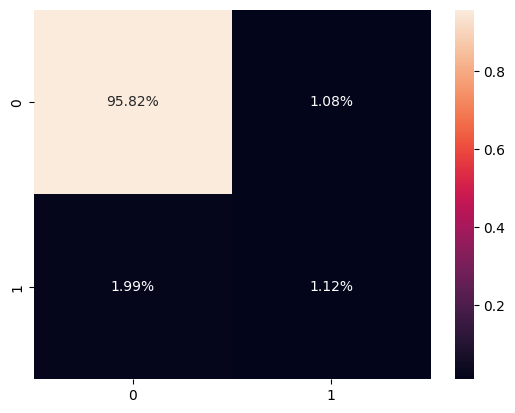

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
import seaborn as sn


y_pred = xgb.predict(X_test.values)
print("Accuracy:", accuracy_score(y_pred, y_test))
print("F1 score: %.3f" % f1_score(y_test, y_pred, average="weighted"))
print("Recall: %.3f" % recall_score(y_test, y_pred, average="weighted"))
print("Precision: %.3f" % precision_score(y_test, y_pred, average="weighted"))
print("AUC Score: %.3f" % roc_auc_score(y_test, y_pred, average="weighted"))

print("Classification report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred)
sn.heatmap(conf_mat/np.sum(conf_mat), annot=True,  fmt='.2%')

In [ ]:
import matplotlib.pyplot as plt

# Accessing feature importances
feature_importances = xgb.feature_importances_

# Pairing feature names with their importance scores
features = X.columns
importance_scores = list(zip(features, feature_importances))

# Sorting the features by importance
sorted_importance_scores = sorted(importance_scores, key=lambda x: x[1], reverse=True)

# Plotting the feature importance graph
plt.figure(figsize=(12, 8))
plt.bar(
    range(len(sorted_importance_scores)),
    [score[1] for score in sorted_importance_scores],
)
plt.xticks(
    range(len(sorted_importance_scores)),
    [score[0] for score in sorted_importance_scores],
    rotation=90,
)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

NameError: name 'xgb' is not defined

In [ ]:
# sorted_importance_scores = [s[0] for s in sorted_importance_scores if s[1] >= 0.02]
sorted_importance_scores

['Quarter',
 'Marketing_Airline_Network',
 'DayofMonth',
 'Operated_or_Branded_Code_Share_Partners',
 'Airline',
 'Operating_Airline',
 'OriginWac',
 'DayofMonth_sin',
 'DayOfWeek',
 'DestWac',
 'CRSDepTimeHH']